### **Fontes de pesquisa:**
> **Artigos** 
- 4 Strategies for Multi-Step Time Series Forecasting: https://machinelearningmastery.com/multi-step-time-series-forecasting/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- Time Series Forecasting as Supervised Learning: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- How to Use XGBoost for Time Series Forecasting: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

> **Documentação**
- Métricas de Avaliação: https://scikit-learn.org/stable/modules/model_evaluation.html

In [1]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv', index_col='inicio_semana', parse_dates=True)
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\pld_norte.csv', index_col='inicio_semana', parse_dates=True)

# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


In [3]:
df = df.drop(columns=['preco_pesado','preco_leve','geracao_hidraulica','geracao_termica','carga_energia','reservatorio_EARM','reservatorio_ENA'])
# df = df[23:len(df)-22]
df

,preco_medio
inicio_semana,
2001-08-04,684.00
2001-08-11,684.00
2001-08-18,684.00
2001-08-25,684.00
2001-09-01,684.00
...,...
2009-11-28,16.31
2009-12-05,16.31
2009-12-12,16.31


<AxesSubplot: xlabel='inicio_semana'>

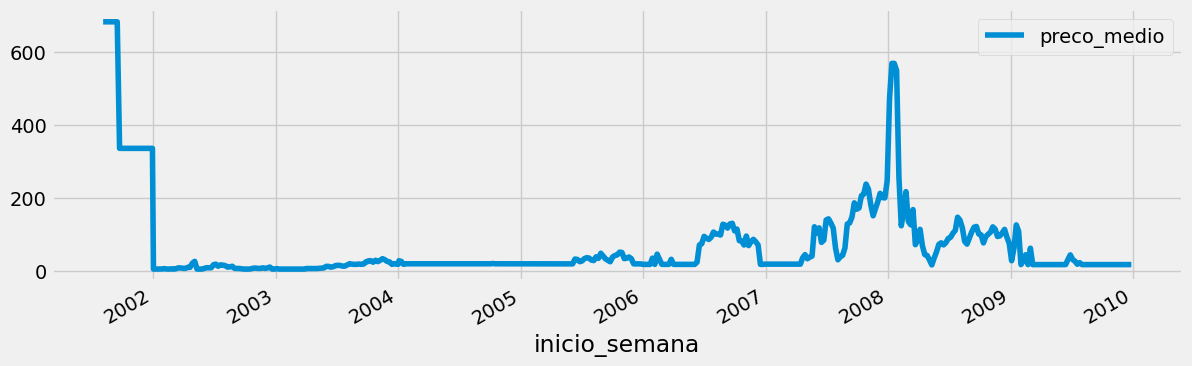

In [4]:
df.plot(figsize=(13,4))

## Pré-processamento
> Separação dos dados em treino / teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [6]:
train_set, test_set = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


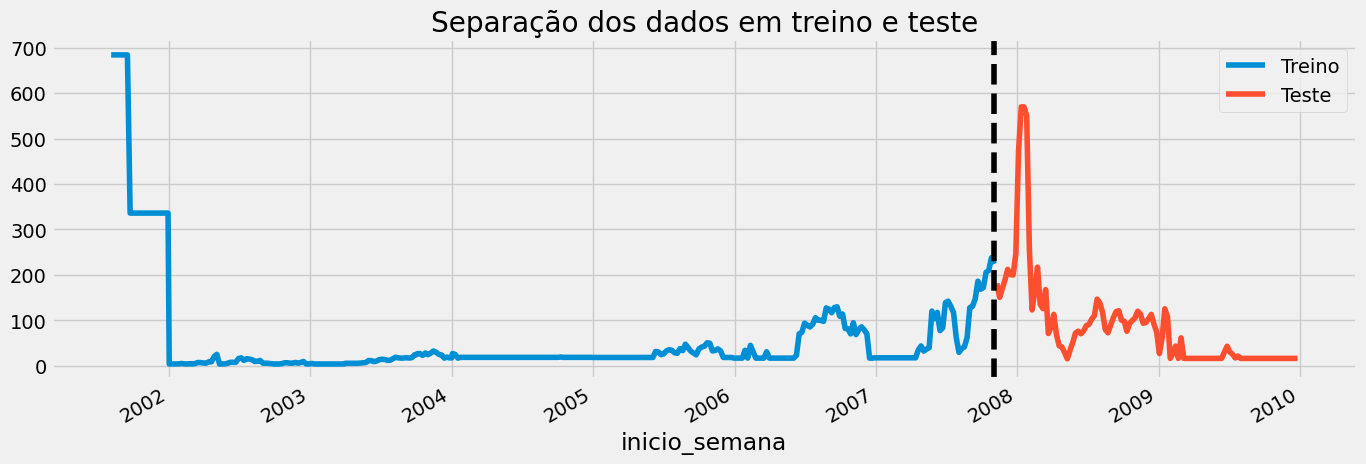

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train_set.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste')
test_set.plot(ax=ax, label='Teste')
ax.axvline('2007-11-03', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.show()

> Feature Engineering

In [8]:
# from pandas import DataFrame
# from pandas import concat

# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('X%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

# tam_janela = 1
# passos = 2
# train_data_features = series_to_supervised(train_set, n_in=tam_janela, n_out=passos)
# test_data_features = series_to_supervised(test_set, n_in=tam_janela, n_out=passos)

In [8]:
def series_to_supervised_lag(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['target+'+str(i)] = serie.shift(-i)
    features = features.dropna() # remove linhas iniciais com nan
    return features

In [9]:
passos = 3
train_data_features = series_to_supervised(serie=train_set, steps_in=passos)
test_data_features = series_to_supervised(serie=test_set, steps_in=passos)

print(train_data_features.tail())
print(test_data_features.head())

                    t  target+1  target+2  target+3
inicio_semana                                      
2007-09-15     147.26    186.16    168.46    172.08
2007-09-22     186.16    168.46    172.08    205.54
2007-09-29     168.46    172.08    205.54    209.96
2007-10-06     172.08    205.54    209.96    237.66
2007-10-13     205.54    209.96    237.66    223.89
                    t  target+1  target+2  target+3
inicio_semana                                      
2007-11-10     181.30    150.54    169.65    189.25
2007-11-17     150.54    169.65    189.25    212.20
2007-11-24     169.65    189.25    212.20    200.48
2007-12-01     189.25    212.20    200.48    199.76
2007-12-08     212.20    200.48    199.76    247.01


In [10]:
X_train = train_data_features.drop(columns=['target+'+str(passos)]).values
y_train = train_data_features.iloc[:,[passos]].values
X_test = test_data_features.drop(columns=['target+'+str(passos)]).values
y_test = test_data_features.iloc[:,[passos]].values

In [11]:
print('X Test: ', X_test[0])
print('y Test: ', y_test[0])

X Test:  [181.3  150.54 169.65]
y Test:  [189.25]


In [12]:
svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
svr.fit(X_train, y_train)

# Verifica a acurácia
# print(f'O ponto de acurácia do modelo é {svr.score(X_test, y_test):.4f}')

SVR(C=6.95, epsilon=0.048)

In [13]:
i = 0
print("ITERAÇÃO ", i)
print("X Teste: ", X_test.reshape(1, -1))
print("y Teste: ", y_test.reshape(1, -1))

print("\nX Predicao: ", X_test[i])
_1passos = svr.predict([X_test[i]])
print("y Real: ", y_test[i])
print("Predito: ", _1passos)

ITERAÇÃO  0
X Teste:  [[181.3  150.54 169.65 150.54 169.65 189.25 169.65 189.25 212.2  189.25
  212.2  200.48 212.2  200.48 199.76 200.48 199.76 247.01 199.76 247.01
  473.3  247.01 473.3  569.59 473.3  569.59 569.59 569.59 569.59 550.28
  569.59 550.28 256.05 550.28 256.05 122.93 256.05 122.93 163.45 122.93
  163.45 216.94 163.45 216.94 135.19 216.94 135.19 125.78 135.19 125.78
  167.6  125.78 167.6   71.08 167.6   71.08  85.23  71.08  85.23 113.25
   85.23 113.25  68.18 113.25  68.18  43.94  68.18  43.94  41.33  43.94
   41.33  29.32  41.33  29.32  15.47  29.32  15.47  34.29  15.47  34.29
   51.11  34.29  51.11  71.85  51.11  71.85  76.16  71.85  76.16  70.51
   76.16  70.51  76.72  70.51  76.72  88.11  76.72  88.11  91.32  88.11
   91.32 102.58  91.32 102.58 110.23 102.58 110.23 146.66 110.23 146.66
  138.64 146.66 138.64 117.87 138.64 117.87  80.13 117.87  80.13  72.65
   80.13  72.65 105.83  72.65 105.83 119.06 105.83 119.06 121.19 119.06
  121.19 100.39 121.19 100.39  98.1  100.3

> Otimização por busca bayesiana

In [132]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

def baye_search(C_min=1e-4, C_max=10000.0, epsilon_min=1e-1, epsilon_max=1.0):
    ts_cv = TimeSeriesSplit(n_splits=5)

    # log-uniform: understand as search over p = exp(x) by varying x
    opt = BayesSearchCV(
        SVR(),
        {
            # 'C': Real(1e-4, 10000.0, prior='log-uniform'),
            'C':Real(C_min, C_max, prior='log-uniform'),
            'gamma': Real(1e-10, 15.0, prior='log-uniform'),
            # 'degree': Integer(1, 5),
            # 'epsilon': Real(1e-3, 1.0),
            'epsilon': Real(epsilon_min, epsilon_max),
            # 'kernel': Categorical(['linear', 'poly', 'rbf']),
        },
        n_iter=32,
        # cv=kfold,
        cv=ts_cv,
        scoring='neg_mean_squared_error',
        random_state=0
    )

    return opt

## Previsão em Etapas de Tempo

In [141]:
def fit_predict_steps(passos=1, otimizacao=False, C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07):
    predicted = []
    yTrue = []
    mae_error = []
    mse_error = []

    for i in range(1, passos+1):
        train_data_features = series_to_supervised(serie=train_set, steps_in=i)
        test_data_features = series_to_supervised(serie=test_set, steps_in=i)

        X_train = train_data_features.drop(columns=['target+'+str(i)]).values
        y_train = train_data_features.iloc[:,[i]].values
        X_test = test_data_features.drop(columns=['target+'+str(i)]).values
        y_test = test_data_features.iloc[:,[i]].values

        # treina o modelo
        if otimizacao:
            opt = baye_search(C_min=1e-2, C_max=1000.0)
            opt.fit(X_train, y_train)
            C, epsilon, gamma = [opt.best_estimator_.C, opt.best_estimator_.epsilon, opt.best_estimator_.gamma]
        svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
        svr.fit(X_train, y_train)

        pred = svr.predict([X_test[0]])
        true = y_test[0]
        mae = mean_absolute_error(pred, true)
        mse = mean_squared_error(pred, true)

        print('[{}] Real: {} || Predito: {} || MAE: {} => SVR(C={}, epsilon={}, gamma={})'.format(i, true, pred, mae, C, epsilon, gamma))

        predicted.append(pred)
        yTrue.append(true)
        mae_error.append(mae)
        mse_error.append(mse)

    return predicted, yTrue, mae_error, mse_error

In [152]:
def plot_result(predictions, y_true, mae=0, mse=0, rmse=0, title='', xlabel=''):
    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_true, label='Real')
    plt.plot(predictions, label='Previsto')
    if (mae != 0) | (mse != 0) | (rmse != 0):
        plt.title(f'{title}\nMSE: {mse:.3f} || RMSE: {rmse:.3f} || MAE: {mae:.3f}')
    else:
        plt.title(f'{title}')
    plt.xlabel('Periodo Observado')
    plt.ylabel(xlabel)
    plt.legend()
    plt.tight_layout()

In [153]:
pred_steps, y_true_steps, mae_steps, mse_steps = fit_predict_steps(passos=12, otimizacao=True)

[1] Real: [150.54] || Predito: [182.87149943] || MAE: 32.331499428435535 => SVR(C=818.2655659905872, epsilon=0.1, gamma=6.430761889709434e-06)
[2] Real: [169.65] || Predito: [152.28478515] || MAE: 17.36521485044659 => SVR(C=684.9456697959627, epsilon=0.7808976154378446, gamma=5.9003480113056856e-06)
[3] Real: [189.25] || Predito: [160.63039647] || MAE: 28.619603532460843 => SVR(C=749.8001428789146, epsilon=1.0, gamma=6.26199581915043e-06)
[4] Real: [212.2] || Predito: [190.64750916] || MAE: 21.552490842233027 => SVR(C=847.7051528692737, epsilon=0.1, gamma=4.620113016399116e-06)
[5] Real: [200.48] || Predito: [210.88195862] || MAE: 10.401958622247093 => SVR(C=1000.0, epsilon=0.1, gamma=2.227863343320524e-06)
[6] Real: [199.76] || Predito: [196.58104682] || MAE: 3.178953177963507 => SVR(C=1000.0, epsilon=0.1, gamma=2.556069149640807e-06)
[7] Real: [247.01] || Predito: [188.54314161] || MAE: 58.46685839284763 => SVR(C=732.3604279723269, epsilon=0.1, gamma=2.424010061393583e-06)
[8] Real: 

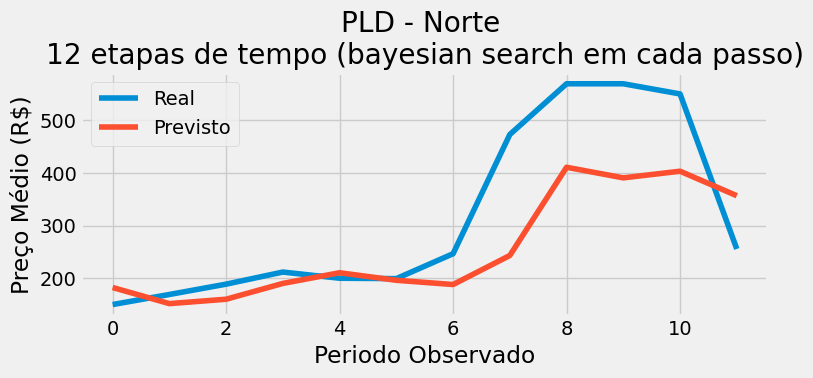

In [154]:
plot_result(predictions=pred_steps, y_true=y_true_steps, title='PLD - Norte \n12 etapas de tempo (bayesian search em cada passo)', xlabel='Preço Médio (R$)')

In [157]:
pred, y_true, mae, mse = fit_predict_steps(passos=12, otimizacao=False)

[1] Real: [150.54] || Predito: [174.06166158] || MAE: 23.521661584763393 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[2] Real: [169.65] || Predito: [146.07704479] || MAE: 23.572955214412445 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[3] Real: [189.25] || Predito: [165.1951191] || MAE: 24.054880904759784 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[4] Real: [212.2] || Predito: [186.85026159] || MAE: 25.349738405019878 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[5] Real: [200.48] || Predito: [212.34282754] || MAE: 11.8628275415588 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[6] Real: [199.76] || Predito: [205.60750308] || MAE: 5.84750308274937 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[7] Real: [247.01] || Predito: [202.91106832] || MAE: 44.098931677045556 => SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)
[8] Real: [473.3] || Predito: [247.49747139] || MAE: 225.8025286145482 => SVR(C=10

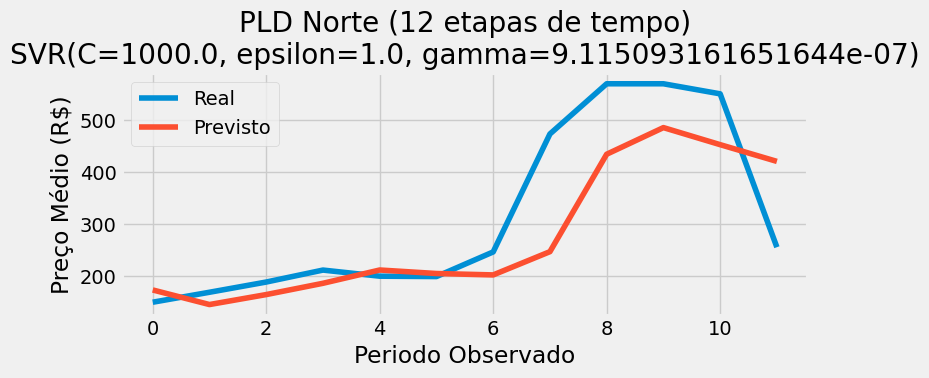

In [158]:
plot_result(predictions=pred, y_true=y_true, title='PLD Norte (12 etapas de tempo)\nSVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)', xlabel='Preço Médio (R$)')

> comparando os resultados

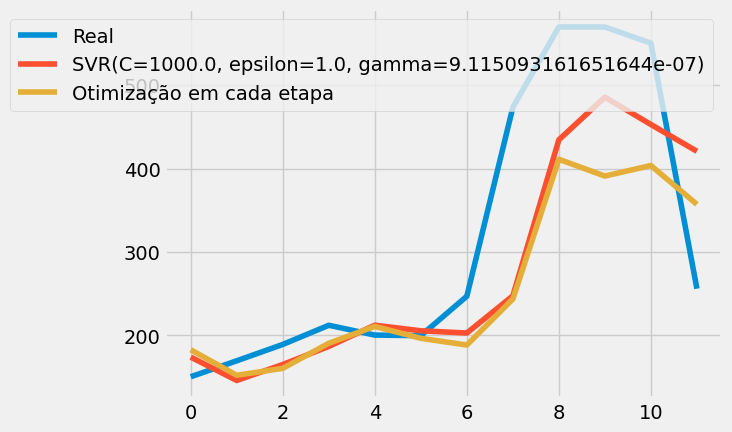

In [159]:
plt.plot(y_true, label='Real')
plt.plot(pred, label='SVR(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07)')
plt.plot(pred_steps, label='Otimização em cada etapa')
plt.legend()

In [160]:
passos = []
for i in range(1,13):
    passos.append(i)

dataset_result = pd.DataFrame()
dataset_result['Passos'] = passos
dataset_result['Real'] = y_true
dataset_result['SVR(C, epsilon, gamma)'] = pred
dataset_result['MSE 1'] = mse
dataset_result['MAE 1'] = mae
dataset_result['BayeSearch por etapa'] = pred_steps
dataset_result['MSE 2'] = mse_steps
dataset_result['MAE 2'] = mae_steps
dataset_result

,Passos,Real,"SVR(C, epsilon, gamma)",MSE 1,MAE 1,BayeSearch por etapa,MSE 2,MAE 2
0,1,[150.54],[174.06166158476339],553.268564,23.521662,[182.87149942843553],1045.325855,32.331499
1,2,[169.65],[146.07704478558756],555.684218,23.572955,[152.28478514955341],301.550687,17.365215
2,3,[189.25],[165.19511909524022],578.637295,24.054881,[160.63039646753916],819.081706,28.619604
3,4,[212.2],[186.8502615949801],642.609237,25.349738,[190.64750915776696],464.509862,21.552491
4,5,[200.48],[212.3428275415588],140.726677,11.862828,[210.88195862224708],108.200743,10.401959
5,6,[199.76],[205.60750308274936],34.193292,5.847503,[196.58104682203648],10.105743,3.178953
6,7,[247.01],[202.91106832295443],1944.715775,44.098932,[188.54314160715236],3418.373530,58.466858
7,8,[473.3],[247.4974713854518],50986.781929,225.802529,[243.66055054667905],52734.276745,229.639449
8,9,[569.59],[434.423114865175],18270.086837,135.166885,[411.1051156804897],25117.458558,158.484884
9,10,[569.59],[485.5047041311798],7070.336981,84.085296,[391.0052662396009],31892.507132,178.584734


## Previsão Direta

> Separação Treino e Teste

In [12]:
train, test = split_dataset(df, 0.90, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2009-01-17          125.44
2009-01-24          107.59
2009-01-31           16.31
2009-02-07           27.06
2009-02-14           43.44

BASE DE TESTE
                preco_medio
inicio_semana             
2009-02-21           16.31
2009-02-28           61.47
2009-03-07           16.31
2009-03-14           16.31
2009-03-21           16.31


> Feature Engineering

In [13]:
steps_in = 13
train_data_features = series_to_supervised_lag(train, steps_in)
test_data_features = series_to_supervised_lag(test, steps_in)

In [14]:
X_train = train_data_features.drop(columns=['t']).values
y_train = train_data_features['t'].values
X_test = test_data_features.drop(columns=['t']).values
y_test = test_data_features['t'].values

> Busca Bayesiana

In [122]:
opt = baye_search(C_min=1e-2, C_max=1000.0)

# treina o modelo
opt.fit(X_train, y_train)
C, epsilon, kernel, gamma = [opt.best_estimator_.C, 
                             opt.best_estimator_.epsilon, 
                             opt.best_estimator_.kernel,
                             opt.best_estimator_.gamma]
print(opt.best_estimator_)
print(opt.best_params_)
print(opt.best_score_)

SVR(C=1000.0, gamma=9.688731159500935e-07)
OrderedDict([('C', 1000.0), ('epsilon', 0.1), ('gamma', 9.688731159500935e-07)])
-728.1121431239369


In [123]:
svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
# svr = SVR(C=10.0, epsilon=1.0) # 0.14302129853093926
# svr = SVR(C=10.0, epsilon=1.0, gamma=0.1) # -2.4197128674797215
# svr = SVR(C=1000.0, epsilon=1.0) # 0.316891440154776
# svr = SVR(C=762.270204148152, epsilon=1.0) # 0.31646502007985244
# svr = SVR(C=1000.0, epsilon=1.0, gamma=0.0001) # 0.09705739836176719
# svr = SVR(C=1000.0, epsilon=1.0, gamma=0.000001) # 0.39092928846589103 (ajustado)
# svr = SVR(C=1000.0, gamma=9.115093161651644e-07) # 0.3860834330840097
svr.fit(X_train, y_train)
print(svr.score(X_test, y_test))

0.38391704798998916


> Previsão com lag Feature

In [57]:
def predict_svr(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale', lag=1):

    # Criação dos Lags
    steps_in = lag
    train_data_features = series_to_supervised_lag(train, steps_in)
    test_data_features = series_to_supervised_lag(test, steps_in)

    # Definição de X e y
    X_train = train_data_features.drop(columns=['t']).values
    y_train = train_data_features['t'].values.reshape(-1, 1)
    X_test = test_data_features.drop(columns=['t']).values
    y_test = test_data_features['t'].values.reshape(-1, 1)

    # treina o modelo
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    predictions = svr.predict(X_test)
        
    # calculo do erro
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)

    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_test, label='Real')
    plt.plot(predictions, label='Previsto')
    plt.title('PLD (Norte) - {} lags\nMSE: {:.3f} || RMSE: {:.3f} || MAE: {:.3f}'.format(steps_in, mse, rmse, mae))
    plt.xlabel('Periodo Observado')
    plt.ylabel('Preço Médio (R$)')
    plt.legend()
    plt.tight_layout()

    return predictions, y_test

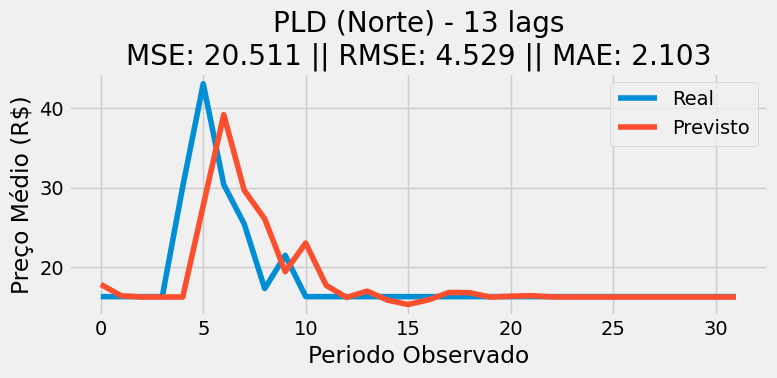

In [131]:
pred, ytrue = predict_svr(C=C, epsilon=epsilon, gamma=gamma, lag=13)

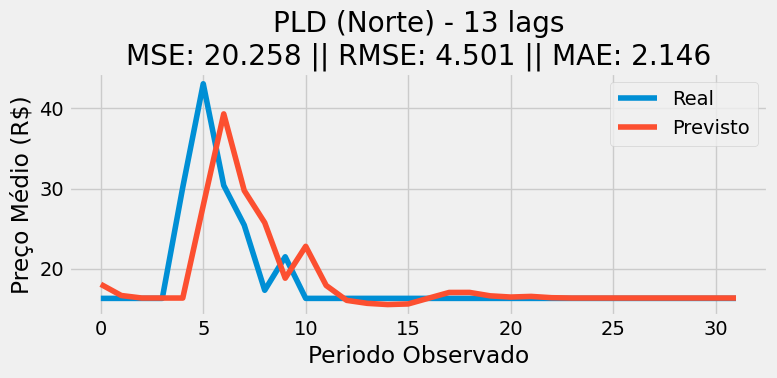

In [110]:
pred, ytrue = predict_svr(C=1000.0, epsilon=1.0, gamma=4.005046866246273e-07, lag=13)

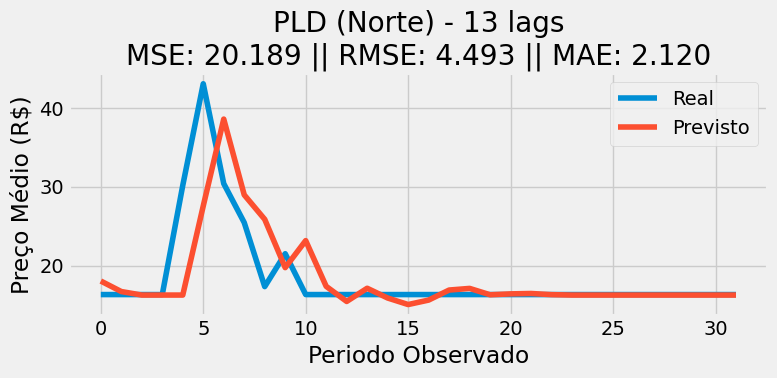

In [149]:
pred, ytrue = predict_svr(C=1000.0, epsilon=1.0, gamma=9.115093161651644e-07, lag=13)

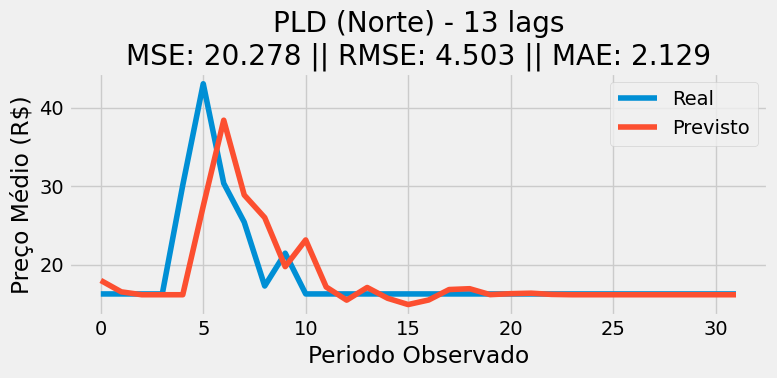

In [71]:
pred, ytrue = predict_svr(C=1000.0, epsilon=1.0, gamma=0.000001, lag=13)

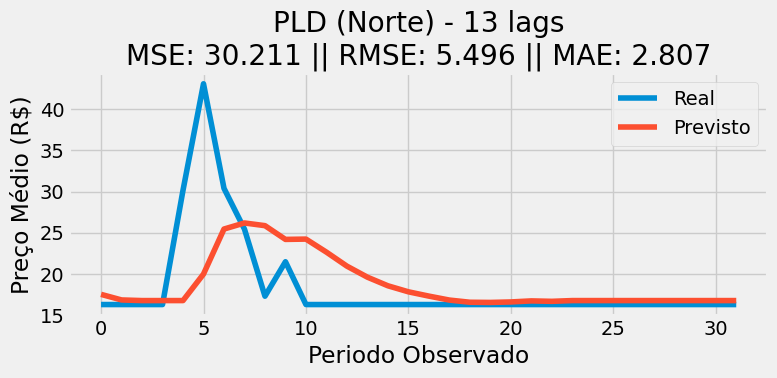

In [52]:
pred, ytrue = predict_svr(C=5.2713416686699786, epsilon=0.0001, lag=13)

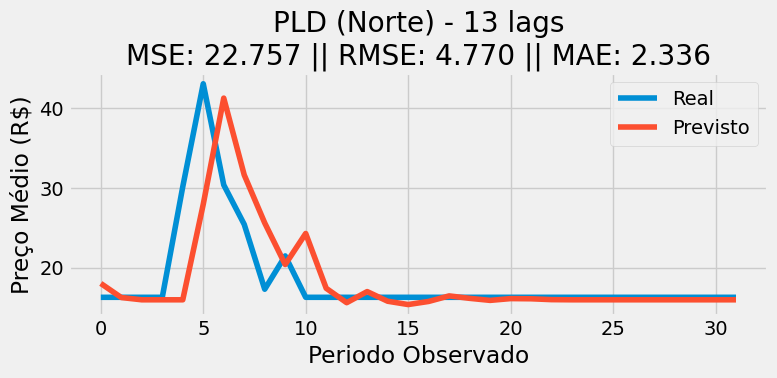

In [22]:
pred, ytrue = predict_svr(C=762.270204148152, epsilon=1.0, lag=13)

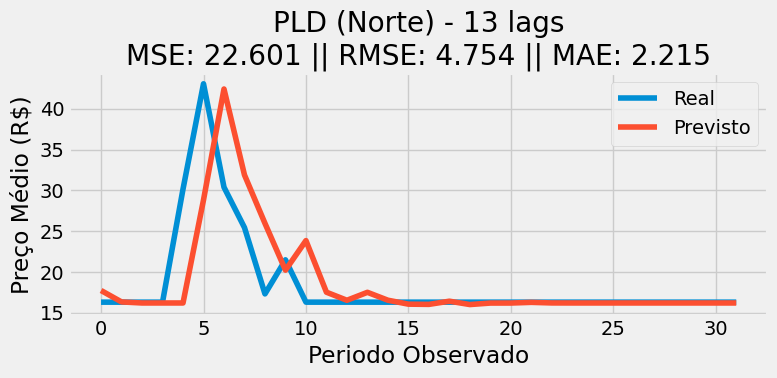

In [37]:
pred, ytrue = predict_svr(C=1000.0, epsilon=0.1, lag=13)

## Analisando os resultados

In [146]:
# svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
# svr = SVR(C=5.2713416686699786, epsilon=0.0001)
svr = SVR(C=C, epsilon=epsilon, gamma=gamma)

# treinando o modelo
svr.fit(X_train, y_train)

# Verifica a acurácia
score = svr.score(X_test, y_test)
print(f'O ponto de acurácia do modelo é {score:.4f}')

O ponto de acurácia do modelo é 0.3839


In [150]:
# calculo do erro
mae = mean_absolute_error(ytrue, pred)
rmse = np.sqrt(mean_squared_error(ytrue, pred))
mse = mean_squared_error(ytrue, pred)

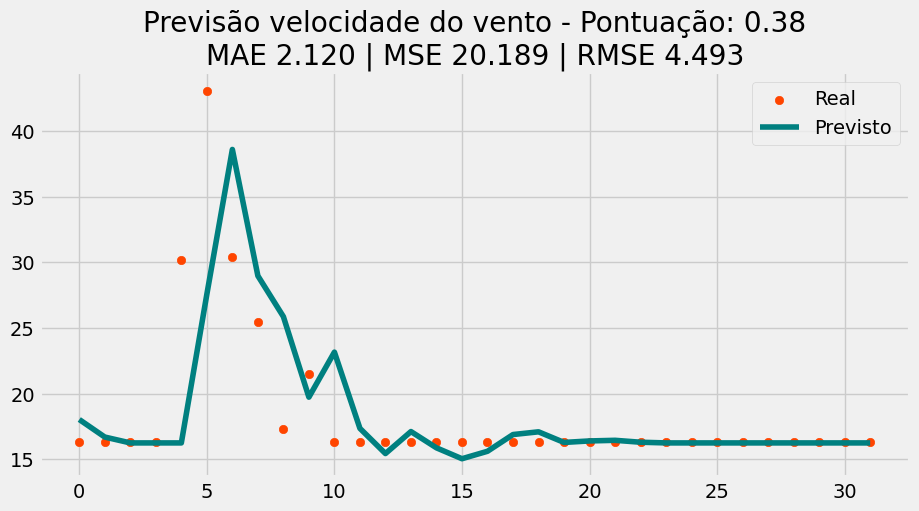

In [151]:
index = []
for i in range(len(ytrue)):
    index.append(i)

fig = plt.subplots(figsize=(10, 5))
plt.scatter(index, ytrue, label='Real', color='orangered')
plt.plot(pred, label='Previsto', color='teal')
plt.title(f'Previsão velocidade do vento - Pontuação: {score:.2f}\nMAE {mae:.3f} | MSE {mse:.3f} | RMSE {rmse:.3f}')
plt.legend()